In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('telcocustomerchurn_data.csv')

In [3]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


# 3.2 Data Preparation

In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [5]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [6]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [7]:
df.totalcharges = df.totalcharges.fillna(0)

In [8]:
df.churn

0        no
1        no
2       yes
3        no
4       yes
       ... 
7038     no
7039     no
7040     no
7041    yes
7042     no
Name: churn, Length: 7043, dtype: object

In [9]:
df.churn = (df.churn == 'yes').astype(int)

# 3.3 Setup validation framework

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [12]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
len(df), len(df_full_train), len(df_train)

(7043, 5634, 4225)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [16]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

# 3.4 EDA

In [17]:
df_full_train = df_full_train.reset_index(drop='True')

In [18]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [19]:
df_full_train.churn.value_counts()

churn
0    4113
1    1521
Name: count, dtype: int64

In [20]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [21]:
global_churn_rate = df_full_train.churn.mean()
global_churn_rate

0.26996805111821087

In [22]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int32
dtype: object

In [23]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [24]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# 3.5 Feature Importance: Churn rate and risk ratio

Churn Rate

In [25]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()

In [26]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()

In [27]:
churn_female, churn_male

(0.27682403433476394, 0.2632135306553911)

In [28]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [29]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [30]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

0.3298090040927694

In [31]:
churn_no_partner / global_churn_rate

1.2216593879412643

``` mysql
SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    ACG(churn) / global_churn AS risk
FROM
    data
GROUP BY
    gender:
```

In [32]:
df_group = df_full_train.groupby(by='gender').churn.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_churn_rate
df_group['risk'] = df_group['mean'] / global_churn_rate
df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [33]:
from IPython.display import display

In [34]:
for c in categorical:
    print (c)
    df_group = df_full_train.groupby(c).churn.agg(['mean','count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)
    print ()

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980



seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208



partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472



dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651



phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412



multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948



internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201



onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570



onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660



deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480



techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390



streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328



streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182



contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730



paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560



paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


# 3.6 Feature Importance: Mutual Information

In [35]:
from sklearn.metrics import mutual_info_score

In [36]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [37]:
mutual_info_score(df_full_train.churn, df_full_train.gender)

0.0001174846211139946

In [38]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [39]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

# 3.7 Feature Importance: Correlation

In [40]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [41]:
df_full_train[df_full_train.tenure <=2].churn.mean()

0.5953420669577875

In [42]:
df_full_train[df_full_train.tenure > 2].churn.mean()

0.22478269658378816

In [43]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

0.32499341585462205

# 3.8 One-Hot Encoding

In [44]:
from sklearn.feature_extraction import DictVectorizer

In [45]:
dicts = df_train[['gender','contract','tenure']].iloc[:100].to_dict(orient='records')

In [46]:
dicts[0]

{'gender': 'female', 'contract': 'two_year', 'tenure': 72}

In [47]:
dv=DictVectorizer(sparse=False)

In [48]:
dv.fit(dicts)

DictVectorizer(sparse=False)

In [49]:
dv.transform(dicts)

array([[ 0.,  0.,  1.,  1.,  0., 72.],
       [ 1.,  0.,  0.,  0.,  1., 10.],
       [ 1.,  0.,  0.,  1.,  0.,  5.],
       [ 1.,  0.,  0.,  1.,  0.,  5.],
       [ 0.,  0.,  1.,  1.,  0., 18.],
       [ 1.,  0.,  0.,  0.,  1.,  4.],
       [ 1.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  1.,  0., 72.],
       [ 1.,  0.,  0.,  1.,  0.,  6.],
       [ 0.,  0.,  1.,  1.,  0., 72.],
       [ 1.,  0.,  0.,  0.,  1., 17.],
       [ 0.,  0.,  1.,  1.,  0., 66.],
       [ 1.,  0.,  0.,  1.,  0.,  2.],
       [ 1.,  0.,  0.,  1.,  0.,  4.],
       [ 1.,  0.,  0.,  0.,  1.,  3.],
       [ 0.,  0.,  1.,  1.,  0., 71.],
       [ 1.,  0.,  0.,  1.,  0., 32.],
       [ 0.,  1.,  0.,  0.,  1., 53.],
       [ 0.,  0.,  1.,  0.,  1., 56.],
       [ 1.,  0.,  0.,  0.,  1., 61.],
       [ 0.,  1.,  0.,  1.,  0., 41.],
       [ 1.,  0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  1.,  0.,  3.],
       [ 1.,  0.,  0.,  0.,  1.,  3.],
       [ 0.,  0.,  1.,  0

In [50]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'gender=female', 'gender=male', 'tenure'],
      dtype=object)

In [51]:
train_dicts=df_train[categorical+numerical].to_dict(orient='records')

In [52]:
train_dicts

[{'gender': 'female',
  'seniorcitizen': 0,
  'partner': 'yes',
  'dependents': 'yes',
  'phoneservice': 'yes',
  'multiplelines': 'yes',
  'internetservice': 'fiber_optic',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'yes',
  'streamingtv': 'yes',
  'streamingmovies': 'yes',
  'contract': 'two_year',
  'paperlessbilling': 'yes',
  'paymentmethod': 'electronic_check',
  'tenure': 72,
  'monthlycharges': 115.5,
  'totalcharges': 8425.15},
 {'gender': 'male',
  'seniorcitizen': 0,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'yes',
  'internetservice': 'fiber_optic',
  'onlinesecurity': 'no',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'no',
  'streamingtv': 'no',
  'streamingmovies': 'yes',
  'contract': 'month-to-month',
  'paperlessbilling': 'yes',
  'paymentmethod': 'electronic_check',
  'tenure': 10,
  'monthlycharges': 95.25,
  'totalcharges': 1021.55},
 {'gender

In [53]:
dv=DictVectorizer(sparse=False)

In [54]:
dv.fit(train_dicts)

DictVectorizer(sparse=False)

In [55]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [56]:
dv.transform(train_dicts[:5])

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.15500e+02, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 7.20000e+01, 8.42515e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 9.52500e+01, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.0

In [57]:
X_train = dv.fit_transform(train_dicts)

In [58]:
X_train.shape

(4225, 45)

In [59]:
val_dicts = df_val[categorical+numerical].to_dict(orient='records')

In [60]:
X_val = dv.transform(val_dicts)

In [61]:
X_val.shape


(1409, 45)

# 3.9 Logistic Regression

In [62]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [63]:
z = np.linspace(-5,5,51)

In [64]:
sigmoid(z)

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])

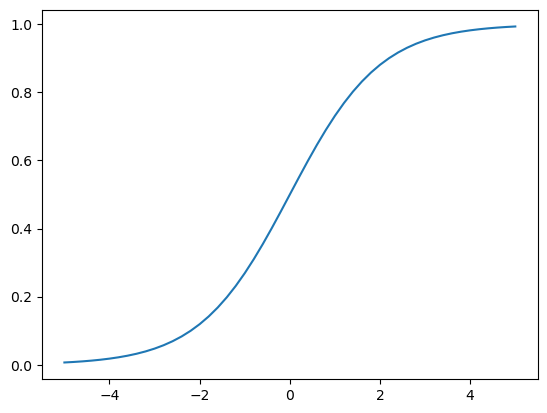

In [65]:
plt.plot(z,sigmoid(z))

In [66]:
sigmoid(0)

0.5

In [67]:
def linear_regression(xi):
    result = w0

    for j in range(len(w)):
        result = result + xi[j] * w[j]
    
    return result


In [68]:
def logistic_regression(xi):
    score = w0

    for j in range(len(w)):
        score = score + xi[j] * w[j]
    
    result = sigmoid(score)
    return result

# 3.10 Training Logistic Regression with Scikit-Learn

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [71]:
#Hard Predictions
model.predict(X_train)

array([0, 1, 1, ..., 1, 0, 1])

In [72]:
#Soft Predictions
model.predict_proba(X_train)

array([[0.90452997, 0.09547003],
       [0.32069545, 0.67930455],
       [0.3663453 , 0.6336547 ],
       ...,
       [0.46840065, 0.53159935],
       [0.95745773, 0.04254227],
       [0.30128646, 0.69871354]])

In [73]:
y_pred = model.predict_proba(X_val)[:,1]
y_pred

array([0.00899556, 0.20453538, 0.2122345 , ..., 0.13637759, 0.79975326,
       0.83739461])

In [74]:
churn_decision = (y_pred >= 0.5)

In [75]:
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 311, dtype: object

In [76]:
y_val

array([0, 0, 0, ..., 0, 1, 1])

In [77]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [78]:
(y_val == churn_decision).mean()

0.8034066713981547

In [79]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val



In [80]:
df_pred['correct'] = df_pred.prediction == df_pred.actual


In [81]:
df_pred

,probability,prediction,actual,correct
0,0.008996,0,0,True
1,0.204535,0,0,True
2,0.212234,0,0,True
3,0.543016,1,1,True
4,0.213794,0,0,True
...,...,...,...,...
1404,0.313676,0,0,True
1405,0.039355,0,1,False
1406,0.136378,0,0,True
1407,0.799753,1,1,True


In [82]:
df_pred.correct.mean()

0.8034066713981547

# 3.11 Model Interpretation

In [84]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [87]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [90]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [91]:
small = ['contract', 'tenure','monthlycharges']

In [94]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [95]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [96]:
dv_small=DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [97]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [98]:
X_train_small = dv_small.transform(dicts_train_small)

In [99]:
model_small = LogisticRegression()

In [100]:
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [101]:
model_small.intercept_[0]

-2.4767756611394978

In [104]:
w=model_small.coef_[0]
w.round(3)

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [105]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

# 3.12 Using the Model

In [106]:
dicts_full_train = df_full_train[categorical+numerical].to_dict(orient='records')

In [107]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [108]:
y_full_train = df_full_train.churn.values

In [109]:
model = LogisticRegression()
model.fit(X_full_train,y_full_train)

LogisticRegression()

In [110]:
dicts_test = df_test[categorical+numerical].to_dict(orient='records')

In [111]:
X_test = dv.transform(dicts_test)

In [112]:
y_pred= model.predict_proba(X_test)[:,1]

In [113]:
churn_decision = (y_pred >= 0.5)

In [114]:
(churn_decision == y_test).mean()

0.815471965933286

In [116]:
customer = dicts_test[10]
customer

{'gender': 'male',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'mailed_check',
 'tenure': 32,
 'monthlycharges': 93.95,
 'totalcharges': 2861.45}

In [119]:
X_small = dv.transform([customer])

In [121]:
model.predict_proba(X_small)[0,1]

0.4056810977883136